# Spherical Shell Test Case 
# Magnetic Shell in Homogeneous External Field    

## Import Packages

In [1]:
using CoordinateTransformations
using ForwardDiff
using QuadGK
using HCubature 
using StaticArrays 
using StructArrays
using LinearAlgebra
using BenchmarkTools
using Plots

In [2]:
const Point3D = SVector{3,Float64};

## Section 1: Introduction 

The goals of this notebook include: 
1. gain familiarity with the implementation of the spherical coordinate system in [CoordinateTransformations.jl](https://github.com/JuliaGeometry/CoordinateTransformations.jl) to define the spherical coordinate systems. These definitions thus differ from the master thesis of Lisette; 
2. study the sensitivity of the analytical reference solution $\vec{A} = (0, A_{\theta}(r,\phi),0)$ and the magnetization vector $\vec{M} = (M_r(r,\phi),0,M_{\phi}(r,\phi))$ wrt variations in the parameters (shell thickness andf thus curvature); 
3. study the explicit computation of $A_{\theta}(r,\phi)$ given the analytical expression for $M_r(r,\phi)$ and $M_{\phi}(r,\phi)$ or the expansion of these components in basis functions as a check/verification on the use of the function for quadrature. Report of the number of function evaluations for the diagonal and off-diagonal terms;
4. study the implicit computation of $M_r(r,\phi)$ and $M_{\phi}(r,\phi)$ by assembling and solving a linear system for these components; 

## Section 2: Info on Spherical Coordinate System 

In [1]:
# ?Spherical

### MWE for integration in spherical coordinates 

In [4]:
function foo(r)
    r2 = Spherical(r[1],r[2],r[3])
    return CartesianFromSpherical()(r2)
end 

foo (generic function with 1 method)

In [5]:
hcubature(r -> foo(r)*r[1]^2*sin(r[2]), (1,0,-π/2), (2,2*π,π/2))

([4.6932943642552516e-15, 23.561944901913293, -2.0556473190325164e-14], 3.50866386371784e-7)

### Non-Singular Integration Kernel 

Given 
1. the domain $\Omega_m$ parametrized by $R_a \leq r \leq R_b$, $0 \leq \theta \leq 2 \pi$ and $-\pi/2 \leq \phi \leq \pi/2$, and with volume $\text{vol}(\Omega_m) = 4/3 \pi (R_b^3 - R_a^3)$
2. the observation location $\vec{r}$ with spherical coordinates $\vec{r}(r,\theta,\phi)$

compute the integral 

$ \vec{V}(r,\theta,\phi) 
  = \int_{\Omega_m} ( \vec{r} -\vec{r}_p ) \, d\Omega 
  = \int_{\Omega_m} [ \vec{r}(r,\theta,\phi) -\vec{r}_p(r_p,\theta_p,\phi_p) ]
    \, d\Omega $
    
and compare with the analytical reference solution $\text{vol}(\Omega_m) \, \vec{r}$.

<b>Remark</b>

This assignment is valuable as test on the conversion between spherical and cartesian coordinates. 

In [28]:
# input: r: spherical coordinates 
# output: Er: radial (first) basis vector 
# note: radial coordinate left out! - cartesian outlet 
function unitEr(r)
    result = Point3D( cos(r.θ)*cos(r.ϕ), sin(r.θ)*cos(r.ϕ), sin(r.ϕ) ) 
    return result 
end 

unitEr (generic function with 1 method)

In [ ]:
# to do 
function unitEt(r)
    result = Point3D( -sin(r.θ), cos(r.θ), 0 ) 
    return result 
end 

In [ ]:
# to do 
function unitEp(r)
    result = Point3D( 0, 0, 0 ) 
    return result 
end 

In [29]:
r = Spherical(1.,0.,-pi/2)
r.r*unitEr(r)

3-element SVector{3, Float64} with indices SOneTo(3):
  6.123233995736766e-17
  0.0
 -1.0

In [30]:
# inputs: coordinates in Point3D of destination (observer) and source
# output: integrand 
# note:   inputs as in Point3D to comply with hcubature 
function integrandNS(r,rp)
    rSp    = Spherical(r[1],r[2],r[3])
    rpSp   = Spherical(rp[1],rp[2],rp[3]) 
    vecr   = rSp.r*unitEr(rSp)
    vecrp  = rpSp.r*unitEr(rpSp)    
    diff   = vecr - vecrp
    result = diff 
    return result
end 

integrandNS (generic function with 1 method)

In [31]:
r  = Point3D(1.,0.,pi/4)
rp = Point3D(1.,0.,-pi/2)
integrandNS(r,rp)

3-element SVector{3, Float64} with indices SOneTo(3):
 0.7071067811865475
 0.0
 1.7071067811865475

In [32]:
Ra = 1; Rb = 2; 
volOmega = 4/3*pi*(Rb^3 - Ra^3) 
rd = Point3D(1.5,pi/5,0.)
numer = hcubature(rp -> integrandNS(rd,rp)*rp[1]^2*cos(rp[3]), (Ra,0,-pi/2), (Rb,2*π,π/2))[1]
anal = volOmega*CartesianFromSpherical()(Spherical(rd[1], rd[2],rd[3]))
display(numer)
display(anal)

3-element SVector{3, Float64} with indices SOneTo(3):
 35.58242584620792
 25.852145626867237
 -1.3357370765021415e-16

3-element SVector{3, Float64} with indices SOneTo(3):
 35.58242584620682
 25.852145626866392
  0.0

## Section 3: Analytical Solution and Sensitivity towards Parameters  

In [7]:
# magnetic susceptibily value (dimensionless)
chi = 100;

# magnetic permeability of vacuum and magnetic shell (add physical units later) 
mu_0 = 1.25663706212e-6
mu_prime = (mu_0*(1+chi))/mu_0 # (dimensionless) 

# magnetic flux and field strength of unperturbed field (add physical units later) 
B_0 = 10^(-6)   # (Tesla) 
H_0 = B_0/mu_0  

# inner and outer radius of spherical shell (in meters?)
Ra = 19; Rb = 20; # (meters)

# set constants beta1 and gamma1 
beta = -3*(2*mu_prime+1)/((2 * mu_prime + 1)*(mu_prime + 2) - 2 * Ra^3/Rb^3*(mu_prime - 1)^2) * H_0
gamma =  -3*Ra^3*(mu_prime-1)/((2 * mu_prime + 1)*(mu_prime + 2) - 2 * Ra^3/Rb^3*(mu_prime - 1)^2) * H_0

-435.3225125906072

In [8]:
# provide analytical expression for the magnetization vector 
# M.theta = 0
# M.r and M.phi are theta independent 
M(rdest) = Spherical( (-beta+2*gamma/rdest.r^3)*cos(rdest.ϕ), 0, (beta+gamma/rdest.r^3)*sin(rdest.ϕ)) 

# provide analytical expression for the magnetic vector potential  
# A.theta is theta independent   
# A.r = 0 and A.phi = 0 
A(rdest) = Spherical( 0, (-beta*rdest.r/2+gamma/rdest.r^2)*sin(rdest.ϕ), 0) 

A (generic function with 1 method)

In [9]:
# evaluate magnetization in single point 
rd = Spherical(1.5, 0, 0)
valM = M(rd)
valA = A(rd)
typeof(valA)
valA

Spherical(r=0.0, θ=-0.0 rad, ϕ=0.0 rad)

In [10]:
# evaluates the density for the vector potential 
# expects rdest and rprime input in cartesian format  
function vp_dens(rdest,rprime,M)
    rdest2  = Spherical(rdest[1],rdest[2],rdest[3])
    rprime2 = Spherical(rprime[1],rprime[2],rprime[3])
    diff = CartesianFromSpherical()(rdest2) - CartesianFromSpherical()(rprime2) 
    numer = cross(CartesianFromSpherical()(M(rprime2)),diff)
    denom = norm(diff)
    result = numer/denom^3 
    return result
end 

vp_dens (generic function with 1 method)

In [11]:
rd = Point3D(1.5, 0, 0)
rp = Point3D(1.75, 0., 0.)
vp_dens(rd,rp,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.0
  0.0
 -0.0

In [12]:
rd = Point3D(1.5, 0, 0)
# should fail due to singularity of the integral 
#hcubature(rp -> vp_dens(rd,rp,M)*rp[1]^2*cos(rp[3]), (Ra,0,-pi/2), (Rb,2*π,π/2))[1]

3-element SVector{3, Float64} with indices SOneTo(3):
 1.5
 0.0
 0.0

### Plot Magnetization and Vector Potential Components  

In [2]:
#?contour

In [14]:
# generate mesh in rtp-domain 
# model is azimuthal theta-dependent - Nt can be ke 
Nr = 5; Nt = 2; Np = 5; 
rmesh = range(Ra, stop=Rb, length=Nr)
tmesh = range(0, stop=2*π,length=Nt)
pmesh = range(-π/2, stop=π/2, length=Np);

In [15]:
rtpmesh = [Spherical(ri, tj, pk) for ri in rmesh, tj in tmesh, pk in pmesh] |> StructArray
rtpM = M.(rtpmesh) |> StructArray
rtpA = A.(rtpmesh) |> StructArray
valsMr = rtpM.r[:,1,:]
valsMp = rtpM.ϕ[:,1,:];
valsAt = rtpA.θ[:,1,:];

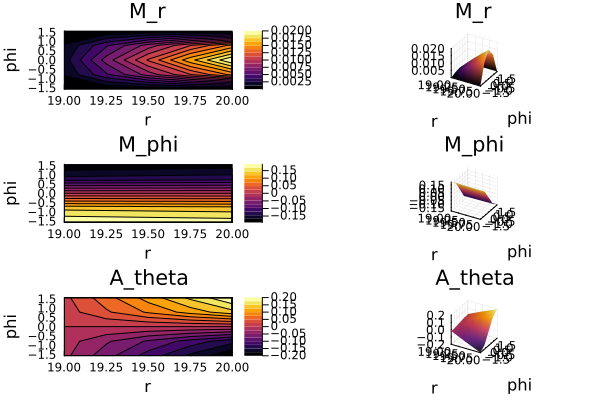

In [16]:
p1 = contourf(rmesh,pmesh,valsMr', xlabel="r", ylabel="phi", title="M_r",color=:inferno)
p2 = surface(rmesh,pmesh,valsMr', xlabel="r", ylabel="phi", title="M_r",cbar=false,color=:inferno)
p3 = contourf(rmesh,pmesh,valsMp', xlabel="r", ylabel="phi", title="M_phi",color=:inferno)
p4 = surface(rmesh,pmesh,valsMp', xlabel="r", ylabel="phi", title="M_phi",cbar=false,color=:inferno)
p5 = contourf(rmesh,pmesh,valsAt', xlabel="r", ylabel="phi", title="A_theta",color=:inferno)
p6 = surface(rmesh,pmesh,valsAt', xlabel="r", ylabel="phi", title="A_theta",cbar=false,color=:inferno)
plot(p1,p2,p3,p4,p5,p6,layout=(3,2))

In [17]:
# valsAtt = rtpA.θ[:,2,];
# plot(valsAtt)

## Section 4: Explicit Computation of Vector Potential given Magnetization Components

In [32]:
# loops over elements in mesh over in magnetization domain,  
# performs 3D integration of cartesian components in spherical coordinates and 
# sums contribution over all elements in the mesh
# singularity is treated by assuming singularities coincide woth boundary of integration
function looprprime(rdest,vp_dens,M,rmesh,tmesh,pmesh)

    Nr = length(rmesh); hr = rmesh[2] - rmesh[1]
    Nt = length(tmesh); ht = tmesh[2] - tmesh[1] # the dependency in \theta can be dropped 
    Np = length(  pmesh); hp = pmesh[2] - pmesh[1]
    partialresult = zeros(Point3D,Nr,Nt,Np)
    for (i,ri) in enumerate(rmesh[1:end-1])
       for (j,tj) in enumerate(tmesh[1:end-1])
          for (k,pk) in enumerate(pmesh[1:end-1])
             partialresult[i,j,k] = hcubature(rp -> vp_dens(rdest,rp,M)*rp[1]*rp[1]*cos(rp[3]), (ri,tj,pk), (ri+hr,tj+ht,pk+hp); rtol = 1e-6)[1]
          end 
       end 
    end
    
    # compute sum of all contributions in the mesh 
    result = sum(partialresult)
    return result 
end 

looprprime (generic function with 1 method)

In [33]:
# generate mesh in rtp-domain  
Nr = 50; Nt = 50; Np = 50; 
rmesh = range(Ra, stop=Rb, length=Nr)
tmesh = range(0, stop=2*π,length=Nt)
pmesh = range(-π/2, stop=π/2, length=Np)

-1.5707963267948966:0.0641141357875468:1.5707963267948966

In [34]:
rd = Point3D(rmesh[end],tmesh[1],pmesh[2])

3-element SVector{3, Float64} with indices SOneTo(3):
 20.0
  0.0
 -1.5066821910073498

In [35]:
rd = Point3D(rmesh[1],tmesh[1],pmesh[2])
cartResult = looprprime(rd,vp_dens,M,rmesh,tmesh,pmesh)
result = SphericalFromCartesian()(cartResult)
result

Spherical(r=0.038826259102077765, θ=1.570796326794897 rad, ϕ=2.1519284074600167e-15 rad)

In [36]:
tmesh

0.0:0.1282282715750936:6.283185307179586

### Integrate for Set of Points in Observer Space: One-Dimensional Sweeps

In [24]:
# generate mesh in rtp-domain  
Nr = 19; Nt = 4; Np = 20; 
rmesh = range(Ra, stop=Rb, length=Nr)
tmesh = range(0, stop=2*π,length=Nt)
pmesh = range(-π/2, stop=π/2, length=Np)

-1.5707963267948966:0.16534698176788384:1.5707963267948966

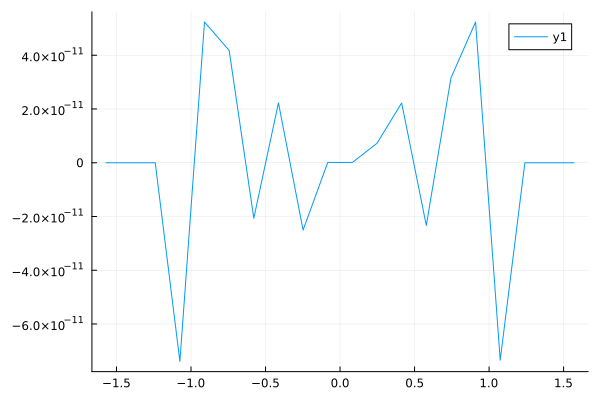

In [37]:
potentialresult = zeros(Np)
for (k,pk) in enumerate(pmesh)
    # display(i)
    rdest = Point3D(rmesh[end],tmesh[1],pk)
    # display(rdest)
    cartResult = looprprime(rdest,vp_dens,M,rmesh,tmesh,pmesh)
    sphResult = SphericalFromCartesian()(cartResult)
    potentialresult[k] = sphResult.ϕ  
    # display(cartResult)
end 
plot(pmesh,potentialresult) 

### Integrate for Set of Points in Observer Space:  Two-Dimensional Sweeps

In [ ]:
potentialresult = zeros(Nr,Np)
for (i,ri) in enumerate(rmesh[1:end-1])
    display(i)
    for (k,pk) in enumerate(pmesh[1:end-1])
        corner = Point3D(ri,tmesh[1],pk)
        cartResult = hcubature(rp -> integrand(corner,rp,M)*rp[1]^2*cos(rp[3]), (Ra,0,-pi/2), (Rb,2*π,π/2);rtol=1e-8)[1]
        sphResult = SphericalFromCartesian()(cartResult)
        potentialresult[i,k] = sphResult.θ 
        # display(cartResult)
   end 
end 
# contourf(rmesh[1:end-1], pmesh[1:end-1], potentialresult') 
contourf(potentialresult') 

In [ ]:
contour(rmesh[1:end-1], pmesh[1:end-1],potentialresult[1:end-1,1:end-1]') 

In [ ]:
size(rpotentialresult')

In [ ]:
result = zeros(Point3D,Nr,Nt,Np)
potentialresult = zeros(Nr,Np)
for (i,ri) in enumerate(rmesh[1:end-1])
    for (j,tj) in enumerate(tmesh[1:end-1])
        for (k,pk) in enumerate(pmesh[1:end-1])
            corner = Point3D(ri,tj,pk)
            cartResult = hcubature(rp -> integrand(corner,rp,M)*rp[1]^2*cos(rp[3]), (Ra,0,-pi/2), (Rb,2*π,π/2);rtol=1e-2)[1]
            result[i,j,k] = SphericalFromCartesian()(cartResult) 
            display(result[i,j,k])
        end 
   end 
end 
display(result) 

## Section 5: Implicit Computation of Magnetization Components